In [233]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

from datetime import datetime


import shutil
import pandas as pd

In [234]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [235]:
dir_str = "./nus-cs5242/"
shutil.rmtree(dir_str + "train_image/class", ignore_errors=True)
os.mkdir(dir_str + "train_image/class")
os.mkdir(dir_str + "train_image/class/0")
os.mkdir(dir_str + "train_image/class/1")
os.mkdir(dir_str + "train_image/class/2")

label = pd.read_csv(dir_str + "train_label.csv")
label_tupple = list(label.itertuples(index=False, name=None))

for i in range(len(label_tupple)):
    img_ext = str(label_tupple[i][0])
    img_class = str(label_tupple[i][1])
    
    shutil.copy(dir_str + "train_image/train_image/"+img_ext+".png", 
                dir_str + "train_image/class/"+img_class+"/"+img_ext+".png")

data_dir=dir_str + "train_image/class"
data_dir = pathlib.Path(data_dir)
print(data_dir)

nus-cs5242/train_image/class


In [236]:
# create tf datasets and load data, note: didn't use graysacle as all pretrained models over imagenet are RGB 
batch_size = 32
img_height = 512
img_width = 512
num_classes = 3

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  #labels=train_labels,
  #label_mode='int',
  #color_mode='grayscale',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names


Found 1164 files belonging to 3 classes.
Using 932 files for training.


In [237]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  #labels=train_labels,
  #color_mode='grayscale',
  #label_mode='int',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1164 files belonging to 3 classes.
Using 232 files for validation.


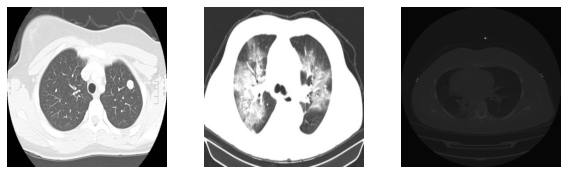

In [238]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")

In [239]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(4, 512, 512, 3)
(4,)


In [240]:
#for image_batch, labels_batch in train_ds:
#    print(labels_batch[0])

In [241]:
#for images, labels in train_ds:
#    plt.imshow(images[1])

In [242]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Test transfer learning model ResNet50

In [243]:
# Create the base model from the pre-trained model MobileNet V2
#base_model = tf.keras.applications.MobileNetV2(input_shape=(512,512,3),
#                                               include_top=False,
#                                               weights='imagenet')


from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

base_model = ResNet50(input_shape=(512,512,3),
                                               include_top=False,
                                               weights='imagenet')


In [244]:
#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [245]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 16, 16, 2048)


In [246]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 165

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
for i, layer in enumerate(base_model.layers):
    print(i,layer.name,"-",layer.trainable)

Number of layers in the base model:  175
0 input_29 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block

In [247]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_29[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [248]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [249]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [250]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Normalization(),
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

In [251]:
# construct model 

inputs = tf.keras.Input(shape=(512, 512, 3))
x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)

# x = tf.keras.layers.Dense(32, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(3, activation='softmax')(x)
# outputs = prediction_layer(x)
model = tf.keras.Model(inputs, x)


In [262]:
base_learning_rate = 0.001
#model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=['accuracy'])

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=base_learning_rate,
    decay_steps=1000,
    decay_rate=0.9)


model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [263]:
model.summary()


Model: "functional_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential_13 (Sequential)   (None, 512, 512, 3)       7         
_________________________________________________________________
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_12  (None, 2048)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_31 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 64)              

In [264]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=True
)

Epoch 1/30
30/30 [==============================] - 22s 728ms/step - loss: 0.6210 - accuracy: 0.9378 - val_loss: 0.6629 - val_accuracy: 0.8836
Epoch 2/30
30/30 [==============================] - 21s 692ms/step - loss: 0.6078 - accuracy: 0.9506 - val_loss: 0.6697 - val_accuracy: 0.8793
Epoch 3/30
30/30 [==============================] - 21s 692ms/step - loss: 0.5982 - accuracy: 0.9646 - val_loss: 0.6354 - val_accuracy: 0.9138
Epoch 4/30
30/30 [==============================] - 20s 682ms/step - loss: 0.5981 - accuracy: 0.9667 - val_loss: 0.6879 - val_accuracy: 0.8578
Epoch 5/30
30/30 [==============================] - 21s 706ms/step - loss: 0.5939 - accuracy: 0.9646 - val_loss: 0.6422 - val_accuracy: 0.8966
Epoch 6/30
30/30 [==============================] - 20s 675ms/step - loss: 0.5822 - accuracy: 0.9796 - val_loss: 0.6496 - val_accuracy: 0.9009
Epoch 7/30
30/30 [==============================] - 21s 689ms/step - loss: 0.5840 - accuracy: 0.9785 - val_loss: 0.7019 - val_accuracy: 0.8319

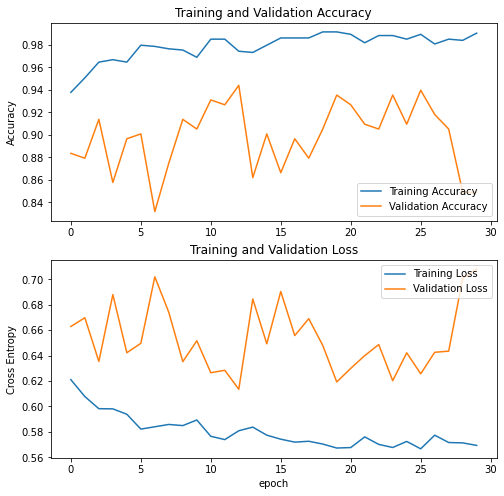

In [265]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
import os

output = []
    
test_folder = dir_str + "test_image/test_image"

for file in os.listdir(test_folder):
    filename = str(file).replace(".png","")
    image_path = os.path.join(test_folder, file)
    #print(filename, image_path)
    
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    label = class_names[np.argmax(score)]
    label = class_names[np.argmax(score)]

    output.append([filename, label])
    #print(
    #    "This image most likely belongs to {} with a {:.2f} percent confidence."
    #    .format(class_names[np.argmax(score)], 100 * np.max(score))
    #)
    

In [ ]:
results = pd.DataFrame(output, columns = ['ID' , 'Label']) 
results.ID = results.ID.astype(int)
results = results.sort_values(by="ID")

In [ ]:
results.to_csv(dir_str + "submission_resnet50_" + datetime.today().strftime('%Y-%m-%d-%H-%M-%S') + ".csv", index=False)